# Data Preprocessing

In [1]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from keras.metrics import Recall

In [2]:
#Check GPU device available
print('Num GPUs Available: ', len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [4]:
# Load dataset
data_train = pd.read_csv('/Data/Visual Studio Code/Data Science/Dataset/UNSW-NB15/UNSW_NB15_training-set.csv')
data_test = pd.read_csv('/Data/Visual Studio Code/Data Science/Dataset/UNSW-NB15/UNSW_NB15_testing-set.csv')

In [5]:
# Handle missing value and duplicate if any
data_train.dropna(inplace=True)
data_train.drop_duplicates(inplace=True)

data_test.dropna(inplace=True)
data_test.drop_duplicates(inplace=True)

In [6]:
#Split Attack and Normal from dataframe
data_train_attack = data_train[data_train['label'] == 1]
data_test_attack = data_test[data_test['label'] == 1]

#Optional
#data_train_normal = data_train[data_train['label'] == 0]
#data_test_normal = data_test[data_test['label'] == 0]

In [7]:
# Drop id and label from train and test data
data_train_attack = data_train_attack.drop('id', axis=1)
data_train_attack = data_train_attack.drop('label', axis=1)

data_test_attack = data_test_attack.drop('id', axis=1)
data_test_attack = data_test_attack.drop('label', axis=1)

In [8]:
print(data_train_attack['state'].nunique())
print(data_test_attack['state'].nunique())

6
5


In [9]:
print(data_train_attack['state'].unique())
print(data_test_attack['state'].unique())

['INT' 'FIN' 'ACC' 'CON' 'REQ' 'CLO']
['INT' 'FIN' 'CON' 'REQ' 'RST']


In [10]:
#Drop ACC, CLO, and RST from data
data_train_attack = data_train_attack[(data_train_attack['state'] != 'ACC') & (data_train_attack['state'] != 'CLO')]
data_test_attack = data_test_attack[(data_test_attack['state'] != 'RST')]

In [11]:
print(data_train_attack['state'].unique())
print(data_test_attack['state'].unique())

['INT' 'FIN' 'CON' 'REQ']
['INT' 'FIN' 'CON' 'REQ']


## Encode Train and Test Data

In [12]:
#column to encode
cols = ['proto','state','service']
cols

['proto', 'state', 'service']

In [13]:
#One-hot Encoding
# Encode train data
data_train_attack = pd.get_dummies(data_train_attack, columns=cols)

# Encode test data
data_test_attack = pd.get_dummies(data_test_attack, columns=cols)

In [14]:
train_attack_cat = data_train_attack.pop('attack_cat')
test_attack_cat = data_test_attack.pop('attack_cat')

## Normalization

In [15]:
# Min-Max Normalization
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
cols_to_norm = ['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl', 'sload', 
                'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 
                'ackdat', 'smean', 'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm', 
                'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm', 
                'ct_srv_dst', 'is_sm_ips_ports']

data_train_attack[cols_to_norm] = scaler.fit_transform(data_train_attack[cols_to_norm])
data_test_attack[cols_to_norm] = scaler.fit_transform(data_test_attack[cols_to_norm])

## Feature Selection

In [16]:
#Feature Selection
feature = data_train_attack.drop(['dinpkt', 'ct_ftp_cmd', 'ct_src_dport_ltm', 'is_sm_ips_ports'], axis=1)
feature.dtypes

dur               float64
spkts             float64
dpkts             float64
sbytes            float64
dbytes            float64
                   ...   
service_radius       bool
service_smtp         bool
service_snmp         bool
service_ssh          bool
service_ssl          bool
Length: 181, dtype: object

# Balancing Data

## Split Data

In [17]:
#Splitting the dataset into dependent and independent feature
X_train = feature
y_train = train_attack_cat

X_test = data_test_attack.drop(columns=['dinpkt', 'ct_ftp_cmd', 'ct_src_dport_ltm', 'is_sm_ips_ports'])
y_test = test_attack_cat

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((45329, 181), (45329,), (119329, 181), (119329,))

## SMOTE

In [18]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X_train, y_train)

X_smote.shape, y_smote.shape

((169839, 181), (169839,))

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'Reconnaissance'),
  Text(1, 0, 'Backdoor'),
  Text(2, 0, 'DoS'),
  Text(3, 0, 'Exploits'),
  Text(4, 0, 'Analysis'),
  Text(5, 0, 'Fuzzers'),
  Text(6, 0, 'Worms'),
  Text(7, 0, 'Shellcode'),
  Text(8, 0, 'Generic')])

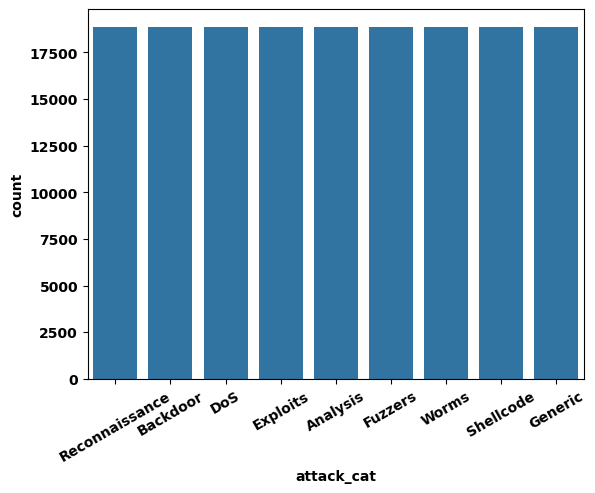

In [19]:
#Create new dataframe from X_smote and y_smote to count every attack
data_smote = pd.concat([X_smote, y_smote], axis=1)

sns.countplot(data=data_smote, x="attack_cat")
plt.xticks(rotation=30)

In [20]:
#data_smote.drop_duplicates(inplace=True)
print(data_smote.value_counts('attack_cat'))
print("--------------------")
print("Shape: " + str(data_smote.shape))
print("--------------------")
print("Duplicates: " + str(data_smote.duplicated().sum()))

attack_cat
Analysis          18871
Backdoor          18871
DoS               18871
Exploits          18871
Fuzzers           18871
Generic           18871
Reconnaissance    18871
Shellcode         18871
Worms             18871
Name: count, dtype: int64
--------------------
Shape: (169839, 182)
--------------------
Duplicates: 47381


# Model Architecture

## 1D-CNN (1 layer) Model

In [21]:
# Define the input shape
input_shape = (181, 1)

# Create the sequential model
model = Sequential()

# Convolutional layers
model.add(Conv1D(filters=32, kernel_size=5, activation='sigmoid', input_shape=input_shape))

# MaxPooling1D layer
model.add(MaxPooling1D(pool_size=2, strides=1))

# Flatten layer
model.add(Flatten())

# Batch Normalization layer
model.add(BatchNormalization(axis=-1))

# Dropout layer with dropout 0.5
model.add(Dropout(0.5))

# Two Fully-connected layers
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))

# Output
model.add(Dense(units=9, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Recall()])

In [22]:
#Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 177, 32)           192       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 176, 32)          0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 5632)              0         
                                                                 
 batch_normalization (BatchN  (None, 5632)             22528     
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 5632)              0         
                                                                 
 dense (Dense)               (None, 32)                1

## Train the model

In [23]:
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

In [24]:
le = LabelEncoder()

y_smote = le.fit_transform(y_smote)
y_test = le.fit_transform(y_test)

In [25]:
num_class = 9
y_smote = to_categorical(y_smote, num_class)
y_test = to_categorical(y_test, num_class)

In [26]:
X_smote = np.array(X_smote, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)

In [27]:
#Define epochs and batch size
epochs = 50
batch_size = 32

#Train the model
history = model.fit(X_smote, y_smote, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test))

Epoch 1/50
5308/5308 [==============================] - 56s 10ms/step - loss: 0.9890 - accuracy: 0.6114 - recall: 0.4564 - val_loss: 1.1057 - val_accuracy: 0.6292 - val_recall: 0.5792
Epoch 2/50
5308/5308 [==============================] - 55s 10ms/step - loss: 0.8610 - accuracy: 0.6577 - recall: 0.5342 - val_loss: 0.9307 - val_accuracy: 0.6684 - val_recall: 0.6073
Epoch 3/50
5308/5308 [==============================] - 57s 11ms/step - loss: 0.8242 - accuracy: 0.6713 - recall: 0.5564 - val_loss: 1.0452 - val_accuracy: 0.6345 - val_recall: 0.5838
Epoch 4/50
5308/5308 [==============================] - 57s 11ms/step - loss: 0.7996 - accuracy: 0.6806 - recall: 0.5707 - val_loss: 0.9299 - val_accuracy: 0.6893 - val_recall: 0.6432
Epoch 5/50
5308/5308 [==============================] - 57s 11ms/step - loss: 0.7840 - accuracy: 0.6876 - recall: 0.5820 - val_loss: 0.9375 - val_accuracy: 0.6889 - val_recall: 0.6479
Epoch 6/50
5308/5308 [==============================] - 56s 10ms/step - loss: 0.

# Evaluate The Model

In [28]:
#Evaluate the model on test data
loss, accuracy, recall = model.evaluate(X_test, y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)
print('Test Recall:', recall)

3730/3730 [==============================] - 16s 4ms/step - loss: 0.9910 - accuracy: 0.6867 - recall: 0.6515
Test Loss: 0.9910194873809814
Test Accuracy: 0.6866562366485596
Test Recall: 0.6515012979507446


In [29]:
# make a predictions
predictions = model.predict(X_test)

3730/3730 [==============================] - 7s 2ms/step


In [30]:
# convert one-hot encode predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)
y_test_categorical = np.argmax(y_test, axis=1)

## Confusion Matrix

In [31]:
# function to calculate recall from confusion matrix
def calculate_recall(confusion_matrix):
    num_class = len(confusion_matrix)
    recalls = []

    for i in range(num_class):
        true_positive = confusion_matrix[i][i]
        false_negative = sum(confusion_matrix[i]) - true_positive

        recall = true_positive / (true_positive + false_negative)
        recalls.append(recall)
    
    return recalls

In [32]:
# function to display the recall score
def display_recall(recalls):
    print('Recall Scores for each class:')
    print('Analysis:', recalls[0])
    print('Backdoor:', recalls[1])
    print('DoS:', recalls[2])
    print('Exploits:', recalls[3])
    print('Fuzzers:', recalls[4])
    print('Generic:', recalls[5])
    print('Reconnaissance:', recalls[6])
    print('Shellcode:', recalls[7])
    print('Worms:', recalls[8])

In [33]:
from sklearn.metrics import confusion_matrix

In [34]:
matrix = confusion_matrix(y_test_categorical, predicted_classes)
matrix_df = pd.DataFrame(matrix, 
                         index= ['Analysis', 'Backdoor', 'DoS', 'Exploits', 'Fuzzers', 'Generic', 'Reconnaissance', 'Shellcode', 'Worms'], 
                         columns= ['Analysis', 'Backdoor', 'DoS', 'Exploits', 'Fuzzers', 'Generic', 'Reconnaissance', 'Shellcode', 'Worms'])

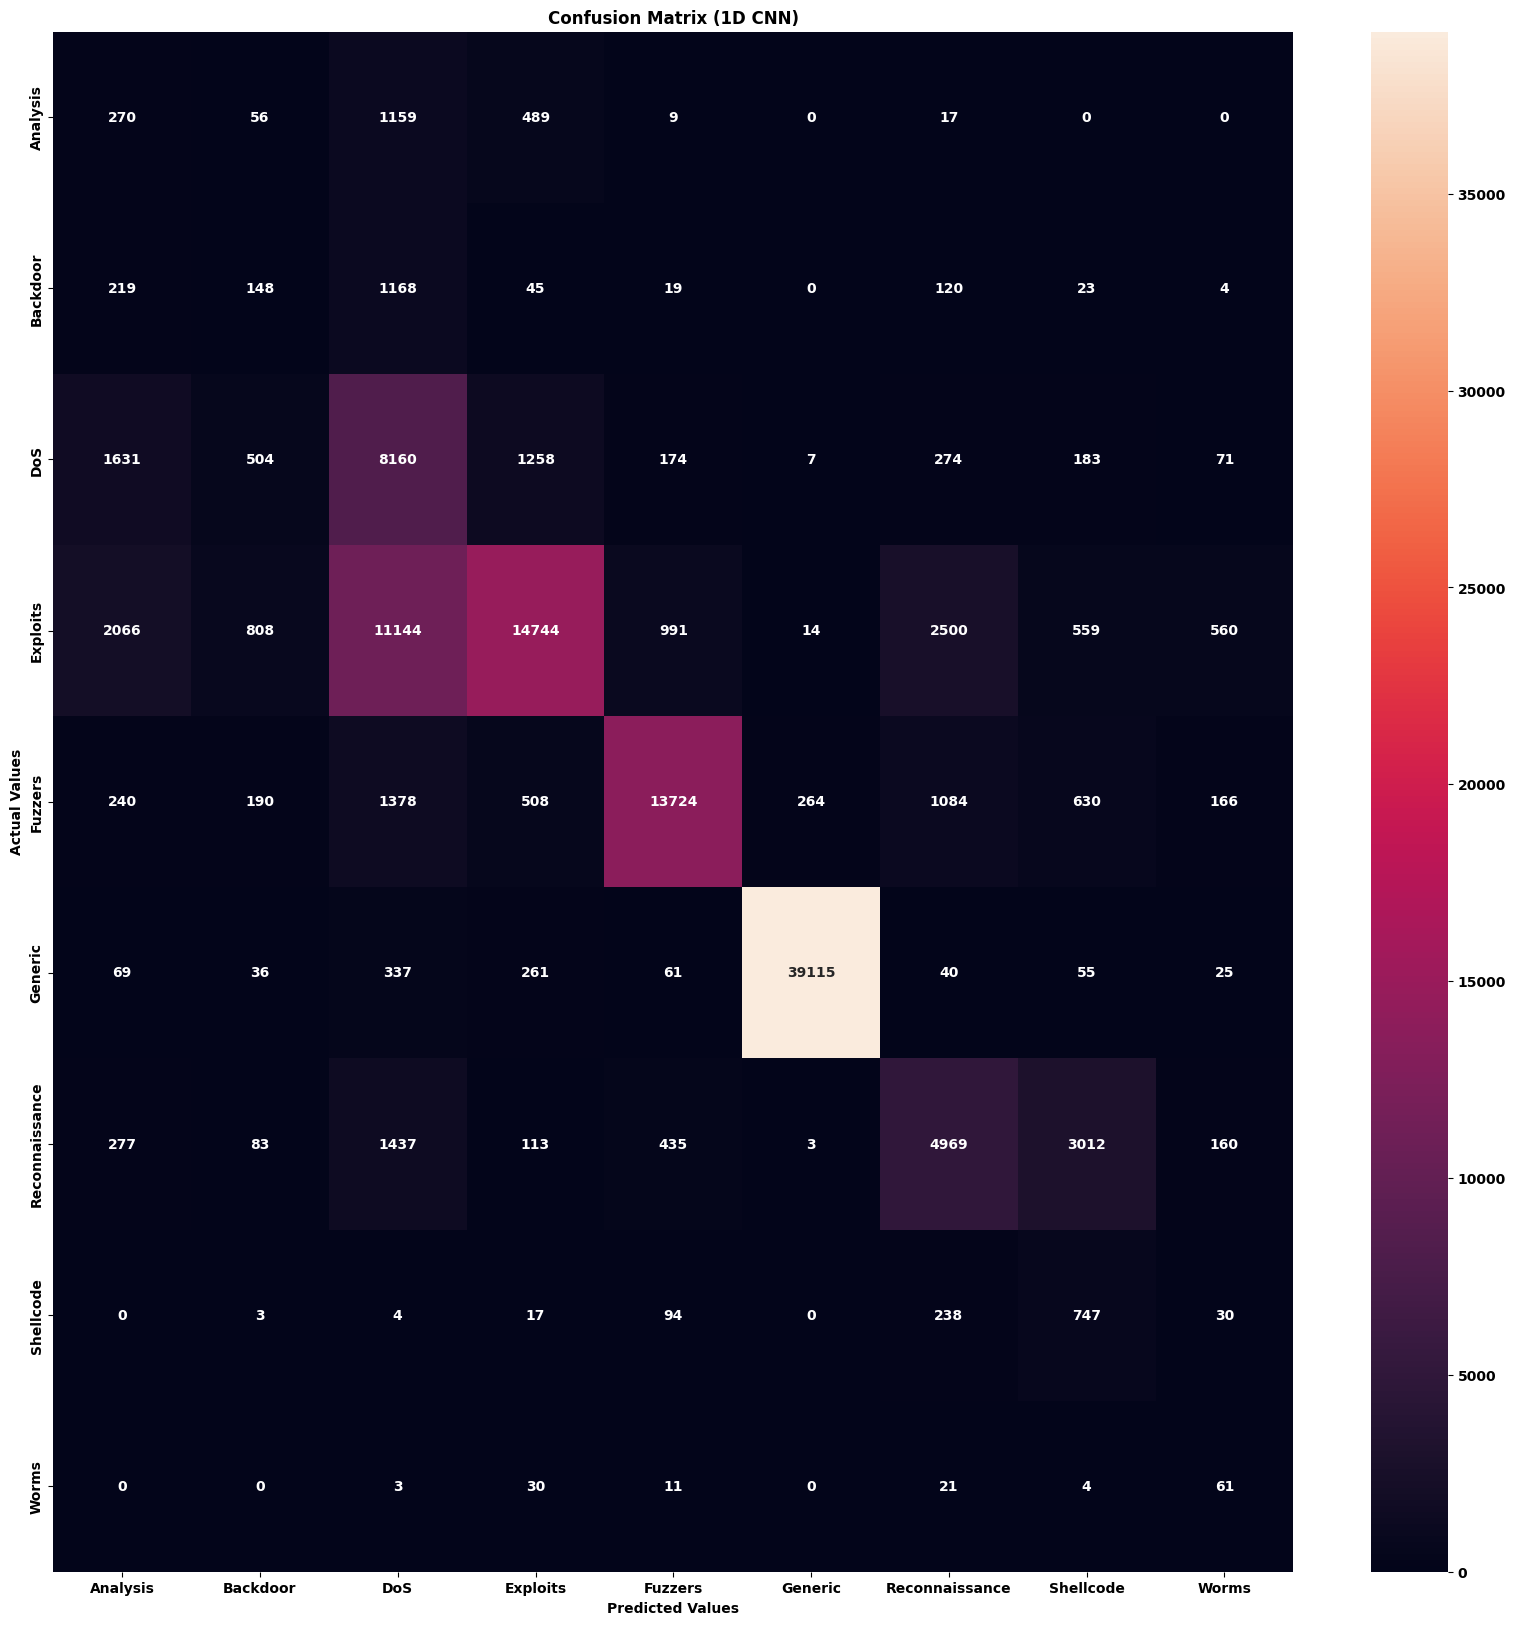

In [35]:
# Plotting Confusion Matrix
plt.figure(figsize = (20, 20))
sns.heatmap(matrix_df, fmt='.0f', annot=True)
plt.title('Confusion Matrix (1D CNN)')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [36]:
recalls = calculate_recall(matrix)
display_recall(recalls)

Recall Scores for each class:
Analysis: 0.135
Backdoor: 0.08476517754868271
DoS: 0.6654705594519654
Exploits: 0.44162223686575214
Fuzzers: 0.7547294324681039
Generic: 0.9778994474861872
Reconnaissance: 0.47373438840690246
Shellcode: 0.6593115622241836
Worms: 0.46923076923076923


## Save and load the model

In [37]:
from keras.models import load_model

In [38]:
# save the 1D CNN trained model using keras
model.save('/Data/Visual Studio Code/Data Science/Notebook/UNSW-NB15/CNN/Balanced/SMOTE/Saved/cnn1d.keras')

In [39]:
# load the 1D CNN trained model using keras
model = load_model('/Data/Visual Studio Code/Data Science/Notebook/UNSW-NB15/CNN/Balanced/SMOTE/Saved/cnn1d.keras')

## Save and load the predicted

In [40]:
import pickle

In [41]:
# save the decision tree trained model
with open('/Data/Visual Studio Code/Data Science/Notebook/UNSW-NB15/CNN/Balanced/SMOTE/Saved/predicted_classes.pkl', 'wb') as model_file:
    pickle.dump(predicted_classes, model_file)

In [42]:
# load the decision tree trained model
with open('/Data/Visual Studio Code/Data Science/Notebook/UNSW-NB15/CNN/Balanced/SMOTE/Saved/predicted_classes.pkl', 'rb') as model_file:
    predicted_classes = pickle.load(model_file)